In [ ]:
pip install torch torchvision torchaudio torchinfo pandas matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 39.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.3/249.3 kB 20.3 MB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)

[notice] A new release of pip available: 22.3.1 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import classification_report
import torchinfo
import torch.nn.functional as F
from torch.profiler import profile, ProfilerActivity, record_function
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [16]:
# Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [ ]:
# Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# Attack Functions

def fgsm_attack(data, epsilon, data_grad):
    perturbed_data = data + epsilon * data_grad.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

def pgd_attack(model, data, target, epsilon, alpha=0.01, iters=40):
    perturbed_data = data.clone().detach().to(device)
    perturbed_data.requires_grad = True

    for _ in range(iters):
        output = model(perturbed_data)
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()
        grad = perturbed_data.grad.data
        perturbed_data = perturbed_data + alpha * grad.sign()

        # Clamp perturbation to epsilon ball
        perturbation = torch.clamp(perturbed_data - data, min=-epsilon, max=epsilon)
        perturbed_data = torch.clamp(data + perturbation, 0, 1).detach_()
        perturbed_data.requires_grad = True

    return perturbed_data


In [ ]:
# Training
def train(model, device, train_loader, optimizer, epoch, adversarial=False, attack_method="fgsm", epsilon=0.3):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        if adversarial:
            data.requires_grad = True
            if attack_method == "fgsm":
                output = model(data)
                loss = criterion(output, target)
                model.zero_grad()
                loss.backward()
                data_grad = data.grad.data
                data = fgsm_attack(data, epsilon, data_grad)

            elif attack_method == "pgd":
                data = pgd_attack(model, data, target, epsilon)

        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
# Testing
def test(model, device, test_loader, adversarial=False, attack_method="fgsm", epsilon=0.3, report=False):
    model.eval()
    correct = 0
    all_preds = []
    all_targets = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        if adversarial:
            if attack_method == "fgsm":
                data.requires_grad = True
                output = model(data)
                loss = criterion(output, target)
                model.zero_grad()
                loss.backward()
                data_grad = data.grad.data
                data = fgsm_attack(data, epsilon, data_grad)

            elif attack_method == "pgd":
                data = pgd_attack(model, data, target, epsilon)

        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    accuracy = 100. * correct / len(test_loader.dataset)

    if report:
        print("\nClassification Report:\n")
        print(classification_report(all_targets, all_preds, digits=4))

    return accuracy

In [23]:
# (1) Train normally

model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("\nTraining normally...")
for epoch in range(1, 3):
    train(model, device, trainloader, optimizer, epoch)
print("\nTesting on clean data:")
test(model, device, testloader, report=True)
print("\nTesting under FGSM attack:")
test(model, device, testloader, adversarial=True, attack_method="fgsm", report=True)
print("\nTesting under PGD attack:")
test(model, device, testloader, adversarial=True, attack_method="pgd", report=True)


Training normally...

Testing on clean data:

Classification Report:

              precision    recall  f1-score   support

           0     0.9949    0.9867    0.9908       980
           1     0.9912    0.9965    0.9938      1135
           2     0.9894    0.9913    0.9903      1032
           3     0.9775    0.9891    0.9833      1010
           4     0.9898    0.9878    0.9888       982
           5     0.9790    0.9910    0.9850       892
           6     0.9916    0.9833    0.9874       958
           7     0.9931    0.9776    0.9853      1028
           8     0.9896    0.9795    0.9845       974
           9     0.9697    0.9822    0.9759      1009

    accuracy                         0.9866     10000
   macro avg     0.9866    0.9865    0.9865     10000
weighted avg     0.9867    0.9866    0.9866     10000


Testing under FGSM attack:

Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       980
        

0.0

In [24]:
# (2) FGSM

model_adv_fgsm = SimpleCNN().to(device)
optimizer_adv_fgsm = optim.Adam(model_adv_fgsm.parameters(), lr=0.001)
print("\nStarting adversarial training (FGSM)...")
for epoch in range(1, 3):
    train(model_adv_fgsm, device, trainloader, optimizer_adv_fgsm, epoch, adversarial=True, attack_method="fgsm")
print("\nTesting adversarially trained model (FGSM) on clean data:")
test(model_adv_fgsm, device, testloader, report=True)
print("\nTesting adversarially trained model (FGSM) under FGSM attack:")
test(model_adv_fgsm, device, testloader, adversarial=True, attack_method="fgsm", report=True)
print("\nTesting adversarially trained model (FGSM) under PGD attack:")
test(model_adv_fgsm, device, testloader, adversarial=True, attack_method="pgd", report=True)


Starting adversarial training (FGSM)...

Testing adversarially trained model (FGSM) on clean data:

Classification Report:

              precision    recall  f1-score   support

           0     0.9933    0.9031    0.9460       980
           1     0.9308    0.9956    0.9621      1135
           2     0.9526    0.9729    0.9626      1032
           3     0.9794    0.9396    0.9591      1010
           4     0.9795    0.9236    0.9507       982
           5     0.9929    0.9350    0.9630       892
           6     0.8837    0.9916    0.9346       958
           7     0.9766    0.8512    0.9096      1028
           8     0.9681    0.9343    0.9509       974
           9     0.8218    0.9732    0.8911      1009

    accuracy                         0.9426     10000
   macro avg     0.9478    0.9420    0.9430     10000
weighted avg     0.9472    0.9426    0.9429     10000


Testing adversarially trained model (FGSM) under FGSM attack:

Classification Report:

              precision    r

0.87

In [ ]:
# (3) PGD

model_adv_pgd = SimpleCNN().to(device)
optimizer_adv_pgd = optim.Adam(model_adv_pgd.parameters(), lr=0.001)
print("\nStarting adversarial training (PGD)...")
for epoch in range(1, 3):
    train(model_adv_pgd, device, trainloader, optimizer_adv_pgd, epoch, adversarial=True, attack_method="pgd")
print("\nTesting adversarially trained model (PGD) on clean data:")
test(model_adv_pgd, device, testloader, report=True)
print("\nTesting adversarially trained model (PGD) under FGSM attack:")
test(model_adv_pgd, device, testloader, adversarial=True, attack_method="fgsm", report=True)
print("\nTesting adversarially trained model (PGD) under PGD attack:")
test(model_adv_pgd, device, testloader, adversarial=True, attack_method="pgd", report=True)

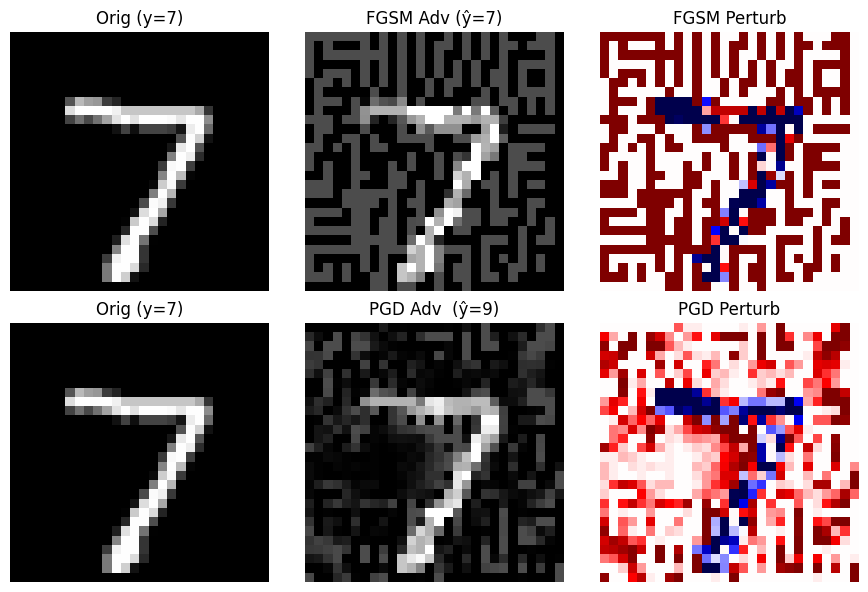

In [26]:

# ─── grab one batch and make attacks ─────────────────────────────────────────

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_adv_fgsm.to(device).eval()    # use your trained model here

# get a single batch
data, target = next(iter(testloader))
data, target = data.to(device), target.to(device)
data.requires_grad = True

# FGSM
output = model(data)
loss   = F.cross_entropy(output, target)
model.zero_grad()
loss.backward()
x_fgsm = fgsm_attack(data, epsilon=0.3, data_grad=data.grad.data)

# PGD
x_pgd = pgd_attack(model, data, target, epsilon=0.3, alpha=0.01, iters=40)

# ─── prepare numpy images ──────────────────────────────────────────────────

idx       = 0
orig_np   = data[idx].cpu().squeeze().detach().numpy()
fgsm_np   = x_fgsm[idx].cpu().squeeze().detach().numpy()
pgd_np    = x_pgd[idx].cpu().squeeze().detach().numpy()
diff_fgsm = fgsm_np - orig_np
diff_pgd  = pgd_np  - orig_np

# recompute preds for titles
with torch.no_grad():
    pred_fgsm = model(x_fgsm).argmax(dim=1)[idx].item()
    pred_pgd  = model(x_pgd ).argmax(dim=1)[idx].item()

# ─── plot 2×3 grid ─────────────────────────────────────────────────────────

fig, axes = plt.subplots(2, 3, figsize=(9, 6))

# row 0: FGSM
axes[0, 0].imshow(orig_np,   cmap="gray")
axes[0, 0].set_title(f"Orig (y={target[idx].item()})")
axes[0, 1].imshow(fgsm_np,   cmap="gray")
axes[0, 1].set_title(f"FGSM Adv (ŷ={pred_fgsm})")
axes[0, 2].imshow(diff_fgsm, cmap="seismic", vmin=-diff_fgsm.max(), vmax=diff_fgsm.max())
axes[0, 2].set_title("FGSM Perturb")

# row 1: PGD
axes[1, 0].imshow(orig_np,   cmap="gray")
axes[1, 0].set_title(f"Orig (y={target[idx].item()})")
axes[1, 1].imshow(pgd_np,    cmap="gray")
axes[1, 1].set_title(f"PGD Adv  (ŷ={pred_pgd})")
axes[1, 2].imshow(diff_pgd,  cmap="seismic", vmin=-diff_pgd.max(), vmax=diff_pgd.max())
axes[1, 2].set_title("PGD Perturb")

for ax in axes.flatten():
    ax.axis("off")

plt.tight_layout()
plt.show()


In [29]:
# Compute and Print Model FLOPs and Parameters
print("\nModel FLOPs and Parameters:")
print(torchinfo.summary(model_adv, input_size=(1, 1, 28, 28)))


Model FLOPs and Parameters:
Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─Conv2d: 1-2                            [1, 64, 24, 24]           18,496
├─MaxPool2d: 1-3                         [1, 64, 12, 12]           --
├─Linear: 1-4                            [1, 128]                  1,179,776
├─Linear: 1-5                            [1, 10]                   1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 12.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.47
Params size (MB): 4.80
Estimated Total Size (MB): 5.27


In [30]:
from torch.profiler import profile, ProfilerActivity, record_function

def profile_step(model,
                 optimizer,
                 attack: str = None,
                 epsilon: float = 0.3,
                 alpha: float = 0.01,
                 pgd_iters: int = 40):
    """
    attack: None | "fgsm" | "pgd"
    """
    # grab one batch
    data, target = next(iter(trainloader))
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        record_shapes=True,
        with_flops=True
    ) as prof:

        # 1) apply adversarial perturbation if requested
        if attack == "fgsm":
            with record_function("FGSM_Attack"):
                data.requires_grad_(True)
                out = model(data)
                loss = criterion(out, target)
                loss.backward()
                grad = data.grad
                data = fgsm_attack(data, epsilon, grad)

        elif attack == "pgd":
            with record_function("PGD_Attack"):
                # pgd_attack does its own forward/backward loop internally
                data = pgd_attack(model, data, target,
                                  epsilon=epsilon,
                                  alpha=alpha,
                                  iters=pgd_iters)

        # 2) the usual update step
        with record_function("Update"):
            out2 = model(data)
            loss2 = criterion(out2, target)
            loss2.backward()
            optimizer.step()

    # sum up FLOPs over all profiled events
    total_flops = sum(evt.flops for evt in prof.key_averages())
    return total_flops

# ─── run all three ────────────────────────────────────────────────────────────
flops_norm = profile_step(model_norm, opt_norm, attack=None)
print(f"Normal training step FLOPs ≈ {flops_norm:,}")

flops_fgsm = profile_step(model_adv, opt_adv, attack="fgsm", epsilon=0.3)
print(f"FGSM training step   FLOPs ≈ {flops_fgsm:,}")

flops_pgd  = profile_step(model_adv, opt_adv,
                          attack="pgd",
                          epsilon=0.3,
                          alpha=0.01,
                          pgd_iters=40)
print(f"PGD training step    FLOPs ≈ {flops_pgd:,}")


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:267: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


Normal training step FLOPs ≈ 1,837,350,912
FGSM training step   FLOPs ≈ 3,674,802,176
PGD training step    FLOPs ≈ 75,337,408,512
